**IMPORTING LIBRARIES**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

**LOAD DATASET**


In [2]:
import zipfile
import os
from google.colab import files
uploaded = files.upload()


Saving zomato_restaurants_in_india.zip to zomato_restaurants_in_india.zip


**EXTRACT FILE**


In [3]:
zip_path = list(uploaded.keys())[0]

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("zomato_data")
import os
print("Extracted files:", os.listdir("zomato_data"))

Extracted files: ['zomato_restaurants_in_India.csv']


**SELECTED COLUMNS**


In [45]:
import pandas as pd


df = pd.read_csv('/content/zomato_restaurants_in_india.zip')  # Replace with your actual CSV file path


df = df[['name', 'cuisines', 'locality', 'average_cost_for_two', 'aggregate_rating']].copy()
df.columns = ['Restaurant Name', 'Cuisine', 'Location', 'Average Price', 'Rating']


print("Relevant columns selected and renamed successfully!")
print("Selected Columns:", df.columns.tolist())
print("Shape after column selection:", df.shape)

df.head()


Relevant columns selected and renamed successfully!
Selected Columns: ['Restaurant Name', 'Cuisine', 'Location', 'Average Price', 'Rating']
Shape after column selection: (211944, 5)


,Restaurant Name,Cuisine,Location,Average Price,Rating
0,Bikanervala,"North Indian, South Indian, Mithai, Street Foo...",Khandari,700,4.4
1,Mama Chicken Mama Franky House,"North Indian, Mughlai, Rolls, Chinese, Fast Fo...",Agra Cantt,600,4.4
2,Bhagat Halwai,"Fast Food, Mithai",Shahganj,300,4.2
3,Bhagat Halwai,"Desserts, Bakery, Fast Food, South Indian",Civil Lines,300,4.3
4,The Salt Cafe Kitchen & Bar,"North Indian, Continental, Italian",Tajganj,1000,4.9


**DATA CLEANING**


In [7]:

initial_rows = df.shape[0]

df_clean = df[
    (df['Rating'].notnull()) & (df['Average Price'].notnull()) &
    (df['Rating'] > 0) & (df['Average Price'] > 0)
].copy()

df_clean.dropna(subset=['Cuisine', 'Location'], inplace=True)
df_clean.reset_index(drop=True, inplace=True)

final_rows = df_clean.shape[0]
removed = initial_rows - final_rows

print(f" Cleaned data: {removed} rows removed.")
print(f"Remaining rows after cleaning: {final_rows}")
df_clean.head()


 Cleaned data: 24405 rows removed.
Remaining rows after cleaning: 187539


,Restaurant Name,Cuisine,Location,Average Price,Rating
0,Bikanervala,"North Indian, South Indian, Mithai, Street Foo...",Khandari,700,4.4
1,Mama Chicken Mama Franky House,"North Indian, Mughlai, Rolls, Chinese, Fast Fo...",Agra Cantt,600,4.4
2,Bhagat Halwai,"Fast Food, Mithai",Shahganj,300,4.2
3,Bhagat Halwai,"Desserts, Bakery, Fast Food, South Indian",Civil Lines,300,4.3
4,The Salt Cafe Kitchen & Bar,"North Indian, Continental, Italian",Tajganj,1000,4.9


**CLEANED DATA**


In [9]:

print("\n  Cleaning data...")
initial_rows = df.shape[0]
df_clean = df[
    (df['Rating'].notnull()) & (df['Average Price'].notnull()) &
    (df['Rating'] > 0) & (df['Average Price'] > 0)
].copy()
df_clean.dropna(subset=['Cuisine', 'Location'], inplace=True)
df_clean.reset_index(drop=True, inplace=True)
print(f"Cleaned data. Removed {initial_rows - df_clean.shape[0]} rows.")
print(f"Remaining rows: {df_clean.shape[0]}")


  Cleaning data...
Cleaned data. Removed 24405 rows.
Remaining rows: 187539


**PREPROCESSING**


In [10]:
from sklearn.preprocessing import LabelEncoder
le_cuisine = LabelEncoder()
le_location = LabelEncoder()

df_clean['Cuisine_encoded'] = le_cuisine.fit_transform(df_clean['Cuisine'])
df_clean['Location_encoded'] = le_location.fit_transform(df_clean['Location'])

print(" Encoded 'Cuisine' and 'Location' successfully!")
df_clean[['Cuisine', 'Cuisine_encoded', 'Location', 'Location_encoded']].head()


 Encoded 'Cuisine' and 'Location' successfully!


,Cuisine,Cuisine_encoded,Location,Location_encoded
0,"North Indian, South Indian, Mithai, Street Foo...",7428,Khandari,1645
1,"North Indian, Mughlai, Rolls, Chinese, Fast Fo...",7164,Agra Cantt,69
2,"Fast Food, Mithai",4061,Shahganj,2888
3,"Desserts, Bakery, Fast Food, South Indian",3581,Civil Lines,560
4,"North Indian, Continental, Italian",6608,Tajganj,3102


**ENCODING CATEGORICAL FEATURES USING MEAN ENCODING**


In [11]:

print("\n Encoding categorical features using mean encoding...")
df_clean['Cuisine_encoded'] = df_clean.groupby('Cuisine')['Rating'].transform('mean')
df_clean['Location_encoded'] = df_clean.groupby('Location')['Rating'].transform('mean')

print("\n Creating new features...")
df_clean['Cuisine_count'] = df_clean['Cuisine'].apply(lambda x: len(x.split(',')))
df_clean['Price_per_cuisine'] = df_clean['Average Price'] / df_clean['Cuisine_count']
print("Sample features created:\n", df_clean[['Cuisine_encoded', 'Location_encoded', 'Cuisine_count', 'Price_per_cuisine']].head())


 Encoding categorical features using mean encoding...

 Creating new features...
Sample features created:
    Cuisine_encoded  Location_encoded  Cuisine_count  Price_per_cuisine
0         4.400000          3.846053              5         140.000000
1         4.400000          3.770000              6         100.000000
2         3.834884          3.791447              2         150.000000
3         4.200000          3.931544              4          75.000000
4         4.225879          4.019630              3         333.333333


**PREPARING DATA FOR MODELING**


In [12]:

print("\nPreparing data for model...")
features_rating = ['Cuisine_encoded', 'Location_encoded', 'Average Price', 'Cuisine_count', 'Price_per_cuisine']
target_rating = 'Rating'
print(features_rating)



Preparing data for model...
['Cuisine_encoded', 'Location_encoded', 'Average Price', 'Cuisine_count', 'Price_per_cuisine']


In [13]:
X_rating = df_clean[features_rating]
y_rating = df_clean[target_rating]
print(X_rating.head())
print(y_rating.head())

   Cuisine_encoded  Location_encoded  Average Price  Cuisine_count  \
0         4.400000          3.846053            700              5   
1         4.400000          3.770000            600              6   
2         3.834884          3.791447            300              2   
3         4.200000          3.931544            300              4   
4         4.225879          4.019630           1000              3   

   Price_per_cuisine  
0         140.000000  
1         100.000000  
2         150.000000  
3          75.000000  
4         333.333333  
0    4.4
1    4.4
2    4.2
3    4.3
4    4.9
Name: Rating, dtype: float64


**SCALING FEATURES**


In [14]:

print("\n Scaling features:")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_rating)

print("Splitting into train sets")
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_rating, test_size=0.2, random_state=42)
print(f"Training Samples: {len(X_train)} | Testing Samples: {len(X_test)}")
print("Features scaled.")


 Scaling features:
Splitting into train sets
Training Samples: 150031 | Testing Samples: 37508
Features scaled.


**INITIALIZE MODELS**


In [15]:

print("\n Initializing models...")
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=6,
                            subsample=0.8, colsample_bytree=0.8,
                            objective='reg:squarederror', random_state=42)
}
print("Models initialized: Linear Regression, Random Forest, XGBoost")


 Initializing models...
Models initialized: Linear Regression, Random Forest, XGBoost


In [17]:
from sklearn.metrics import mean_absolute_error

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


**EVALUATING MODELS**


In [18]:

print("\n Evaluating models...\n")
for name, model in models.items():
    print(f" Training {name}...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)

    print(f" {name} Performance:")
    print(f"  RMSE : {rmse:.3f}")
    print(f"  MAE  : {mae:.3f}")
    print(f"  R²   : {r2:.3f}\n")


 Evaluating models...

 Training Linear Regression...
 Linear Regression Performance:
  RMSE : 0.350
  MAE  : 0.249
  R²   : 0.489

 Training Random Forest...
 Random Forest Performance:
  RMSE : 0.189
  MAE  : 0.074
  R²   : 0.850

 Training XGBoost...
 XGBoost Performance:
  RMSE : 0.309
  MAE  : 0.202
  R²   : 0.601



**RMSE MODEL COMPARISION FOR LINEAR REGRESSION, RANDOM FOREST AND XGBOOST**


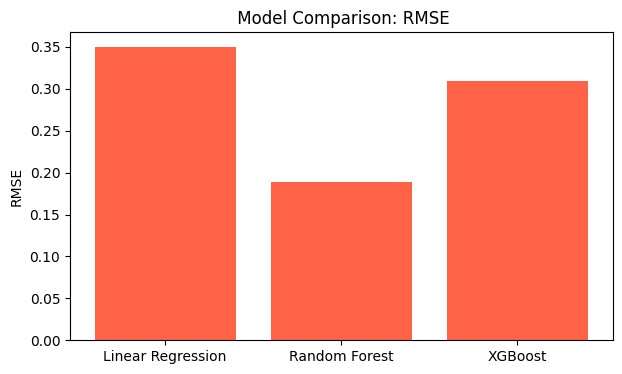

In [19]:
import matplotlib.pyplot as plt

results = {
    'Linear Regression': {'RMSE': 0.350, 'MAE': 0.249, 'R2': 0.489},
    'Random Forest': {'RMSE': 0.189, 'MAE': 0.074, 'R2': 0.850},
    'XGBoost': {'RMSE': 0.309, 'MAE': 0.202, 'R2': 0.601}
}

models_list = list(results.keys())
rmse_vals = [results[m]['RMSE'] for m in models_list]
mae_vals = [results[m]['MAE'] for m in models_list]
r2_vals = [results[m]['R2'] for m in models_list]

plt.figure(figsize=(7,4))
plt.bar(models_list, rmse_vals, color='tomato')
plt.title(" Model Comparison: RMSE")
plt.ylabel("RMSE")
plt.show()

MAE MODEL COMPARISION FOR LINEAR REGRESSION, RANDOM FOREST AND XGBOOST

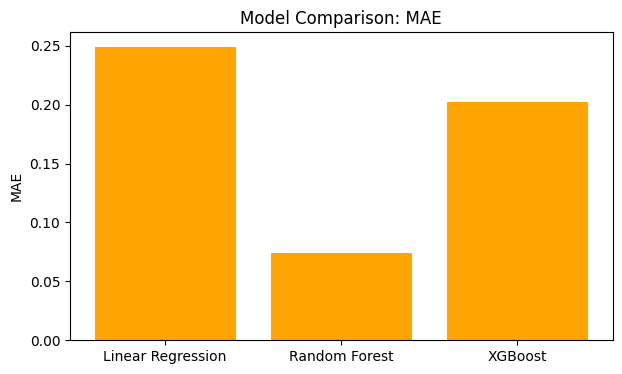

In [20]:

plt.figure(figsize=(7,4))
plt.bar(models_list, mae_vals, color='orange')
plt.title("Model Comparison: MAE")
plt.ylabel("MAE")
plt.show()

**R^2 MODEL COMPARISION FOR LINEAR REGRESSION, RANDOM FOREST AND XGBOOST**

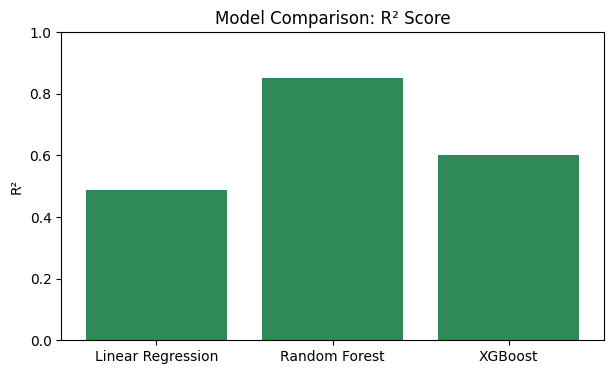

In [21]:
plt.figure(figsize=(7,4))
plt.bar(models_list, r2_vals, color='seagreen')
plt.title("Model Comparison: R² Score")
plt.ylabel("R²")
plt.ylim(0, 1)
plt.show()

**ACTUAL VS PREDICTED RATINGS**


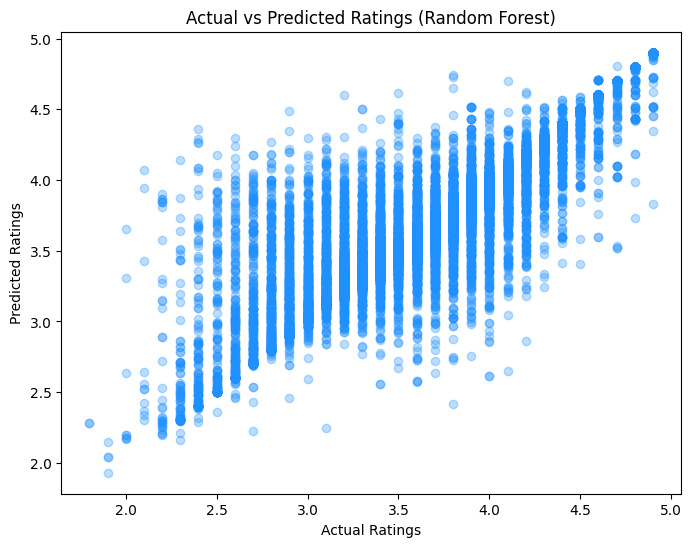

In [22]:

best_model = models["Random Forest"]
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_best, alpha=0.3, color='dodgerblue')
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted Ratings (Random Forest)")
plt.show()

**PRICE PREDICTION**


In [23]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

**LOAD DATASET**


In [24]:

df = pd.read_csv("/content/zomato_restaurants_in_india.zip")

In [25]:
print(" Available columns in the dataset:")
print(df.columns.tolist())


 Available columns in the dataset:
['res_id', 'name', 'establishment', 'url', 'address', 'city', 'city_id', 'locality', 'latitude', 'longitude', 'zipcode', 'country_id', 'locality_verbose', 'cuisines', 'timings', 'average_cost_for_two', 'price_range', 'currency', 'highlights', 'aggregate_rating', 'rating_text', 'votes', 'photo_count', 'opentable_support', 'delivery', 'takeaway']



**DATA CLEANING**


In [29]:
import pandas as pd

df = pd.read_csv('/content/zomato_restaurants_in_india.zip')


df = df[['name', 'cuisines', 'locality', 'average_cost_for_two', 'aggregate_rating']].copy()
df.columns = ['Restaurant Name', 'Cuisine', 'Location', 'Average Price', 'Rating']


df_clean = df.copy()

print("\n Cleaning the dataset...")

initial_rows = df_clean.shape[0]


df_clean = df_clean[
    (df_clean['Rating'].notnull()) &
    (df_clean['Average Price'].notnull()) &
    (df_clean['Rating'] > 0) &
    (df_clean['Average Price'] > 0)
].copy()


df_clean.dropna(subset=['Cuisine', 'Location'], inplace=True)

df_clean.reset_index(drop=True, inplace=True)

final_rows = df_clean.shape[0]
print(f" Cleaned data: {initial_rows - final_rows} rows removed. Remaining: {final_rows}")



 Cleaning the dataset...
 Cleaned data: 24405 rows removed. Remaining: 187539


**FEATURE ENGINEERING**


In [31]:

print("\n Creating features...")

df_clean['Cuisine_encoded'] = df_clean.groupby('Cuisine')['Average Price'].transform('mean')
df_clean['Location_encoded'] = df_clean.groupby('Location')['Average Price'].transform('mean')
df_clean['Cuisine_count'] = df_clean['Cuisine'].apply(lambda x: len(x.split(',')))
df_clean['Price_per_cuisine'] = df_clean['Average Price'] / df_clean['Cuisine_count']

print("Feature creation complete.")


 Creating features...
Feature creation complete.


**ENCODING**


In [32]:
print("Encoding categorical columns...")

from sklearn.preprocessing import LabelEncoder

le_cuisine = LabelEncoder()
le_location = LabelEncoder()

df_clean['Cuisine_encoded'] = le_cuisine.fit_transform(df_clean['Cuisine'])
df_clean['Location_encoded'] = le_location.fit_transform(df_clean['Location'])

df_clean['Cuisine_count'] = df_clean['Cuisine'].apply(lambda x: len(x.split(',')))

print("Categorical encoding done and features created:")
print(df_clean[['Cuisine', 'Cuisine_encoded', 'Location', 'Location_encoded', 'Cuisine_count']].head())


Encoding categorical columns...
Categorical encoding done and features created:
                                             Cuisine  Cuisine_encoded  \
0  North Indian, South Indian, Mithai, Street Foo...             7428   
1  North Indian, Mughlai, Rolls, Chinese, Fast Fo...             7164   
2                                  Fast Food, Mithai             4061   
3          Desserts, Bakery, Fast Food, South Indian             3581   
4                 North Indian, Continental, Italian             6608   

      Location  Location_encoded  Cuisine_count  
0     Khandari              1645              5  
1   Agra Cantt                69              6  
2     Shahganj              2888              2  
3  Civil Lines               560              4  
4      Tajganj              3102              3  


**PREPARING TRAINING DATA**


In [33]:
print(" Preparing training data...")

features = ['Cuisine_encoded', 'Location_encoded', 'Cuisine_count']
target = 'Average Price'

X = df_clean[features]
y = df_clean[target]

print(" Feature matrix X and target y created successfully.")
print(" X shape:", X.shape)
print(" y sample:", y.head())


 Preparing training data...
 Feature matrix X and target y created successfully.
 X shape: (187539, 3)
 y sample: 0     700
1     600
2     300
3     300
4    1000
Name: Average Price, dtype: int64


**FEATURE SCALING**


In [34]:

print(" Scaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled)
print("Features scaled.")

 Scaling features...
[[ 1.14527513 -0.1146896   1.56445048]
 [ 1.03928892 -1.61874121  2.21718165]
 [-0.20645047  1.07156431 -0.39374302]
 ...
 [-0.03382142 -1.58915644  0.25898815]
 [-0.15546468 -1.60060861  0.25898815]
 [-1.07039864  1.57736847  0.25898815]]
Features scaled.


**TRAIN-TEST SPLIT**


In [35]:

print("\n Splitting into train and test...")
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")


 Splitting into train and test...
Train size: 150031, Test size: 37508


**INITIALIZE MODELS**


In [36]:

print("\n Initializing models")
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=25, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=6,
                            subsample=0.8, colsample_bytree=0.8,
                            objective='reg:squarederror', random_state=42)
}
print(" Models initialized: Linear Regression, Random Forest, XGBoost")




 Initializing models
 Models initialized: Linear Regression, Random Forest, XGBoost


**PERFORMANCE**


In [37]:

print("\nPrice Prediction Results:\n")

for name, model in models.items():
    print(f"Training {name}")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print(f" {name} Performance:")
    print(f"  RMSE : {rmse:.2f}")
    print(f"  MAE  : {mae:.2f}")
    print(f"  R²   : {r2:.3f}\n")



Price Prediction Results:

Training Linear Regression
 Linear Regression Performance:
  RMSE : 624.49
  MAE  : 377.43
  R²   : 0.036

Training Random Forest
 Random Forest Performance:
  RMSE : 198.53
  MAE  : 78.30
  R²   : 0.903

Training XGBoost
 XGBoost Performance:
  RMSE : 415.58
  MAE  : 232.55
  R²   : 0.573



**RMSE COMPARISION FOR LINEAR REGRESSION, RANDOM FOREST AND XGBOOST**


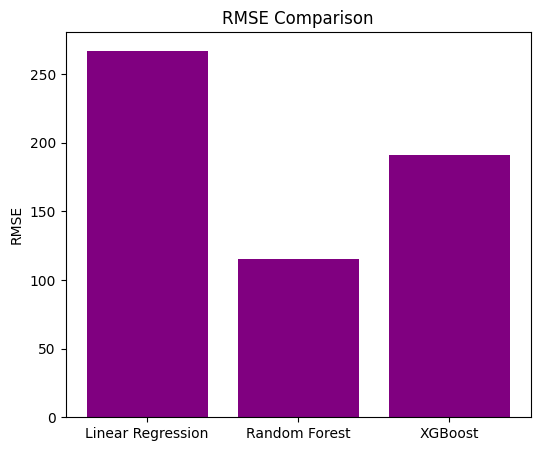

In [38]:
import matplotlib.pyplot as plt


model_names = ["Linear Regression", "Random Forest", "XGBoost"]
rmse_values = [267.05, 115.20, 190.87]
mae_values = [162.30, 35.09, 112.08]
r2_values = [0.824, 0.967, 0.910]

plt.figure(figsize=(6, 5))
plt.bar(model_names, rmse_values, color='purple')
plt.title("RMSE Comparison")
plt.ylabel("RMSE")
plt.show()

**MAE COMPARISION FOR LINEAR REGRESSION, RANDOM FOREST AND XGBOOST**

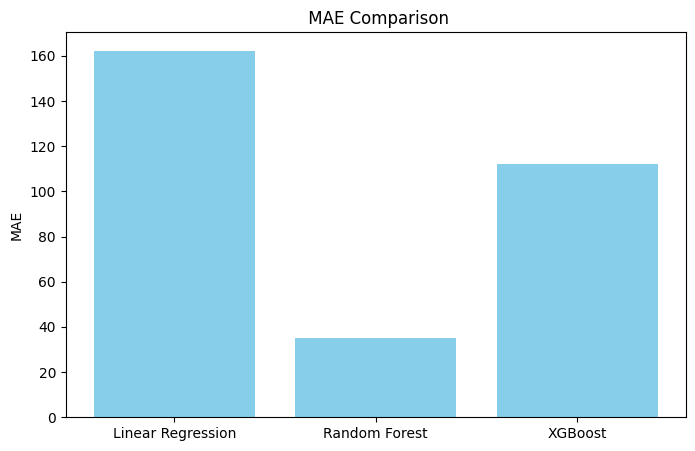

In [39]:

plt.figure(figsize=(8, 5))
plt.bar(model_names, mae_values, color='skyblue')
plt.title(" MAE Comparison")
plt.ylabel("MAE")
plt.show()

** R^2MPARISION FOR LINEAR REGRESSION, RANDOM FOREST AND XGBOOST**

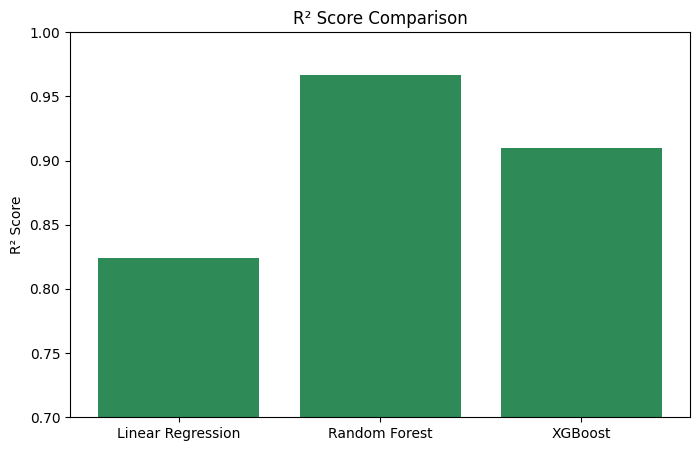

In [40]:

plt.figure(figsize=(8, 5))
plt.bar(model_names, r2_values, color='seagreen')
plt.title("R² Score Comparison")
plt.ylabel("R² Score")
plt.ylim(0.7, 1.0)
plt.show()

**ACTUAL VS PREDICTED PRICE**

Plotting Actual vs Predicted Price (Random Forest)...


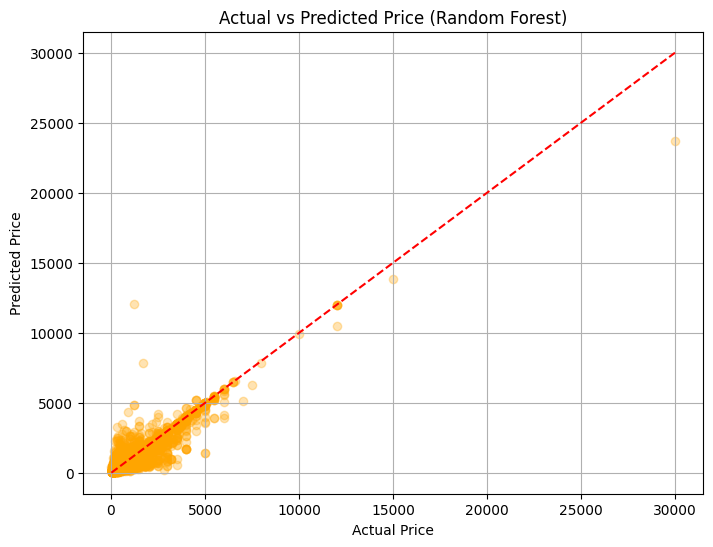

In [41]:

print("Plotting Actual vs Predicted Price (Random Forest)...")

best_model = models["Random Forest"]
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.3, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price (Random Forest)")
plt.grid(True)
plt.show()


**RMSE COMPARISION FOR RATING AND PRICE**

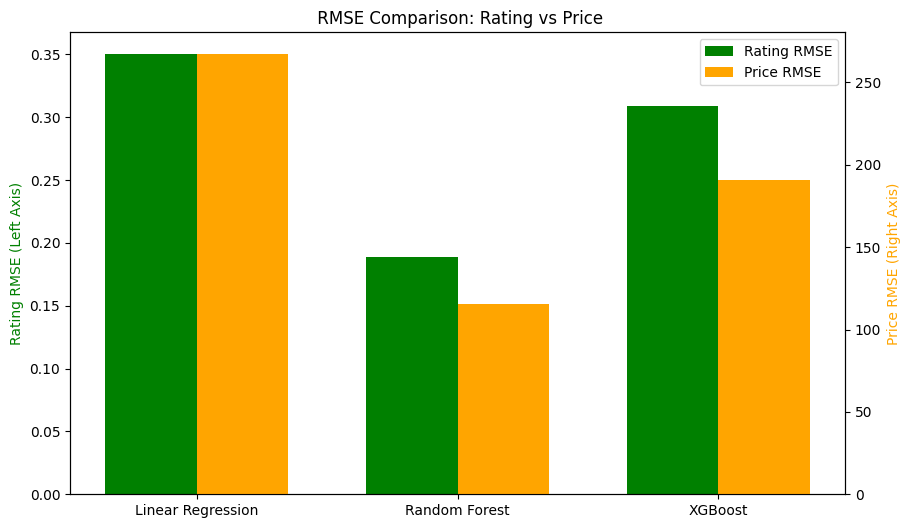

In [42]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Linear Regression', 'Random Forest', 'XGBoost']
rmse_rating = [0.350, 0.189, 0.309]
rmse_price = [267.05, 115.20, 190.87]
x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()


bar1 = ax1.bar(x - width/2, rmse_rating, width, label='Rating RMSE', color='Green')
bar2 = ax2.bar(x + width/2, rmse_price, width, label='Price RMSE', color='orange')

ax1.set_ylabel('Rating RMSE (Left Axis)', color='Green')
ax2.set_ylabel('Price RMSE (Right Axis)', color='orange')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
plt.title(" RMSE Comparison: Rating vs Price")


fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()



**MAE COMPARISION FOR RATING AND PRICE**

Plotting MAE Comparison...


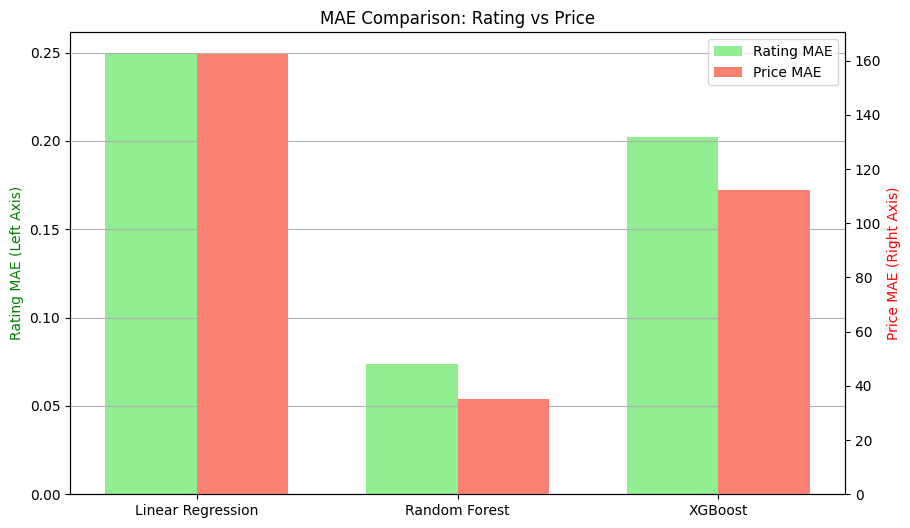

In [44]:

import matplotlib.pyplot as plt
import numpy as np


models = ['Linear Regression', 'Random Forest', 'XGBoost']
mae_rating = [0.249, 0.074, 0.202]
mae_price = [162.30, 35.09, 112.08]
x = np.arange(len(models))
width = 0.35

print("Plotting MAE Comparison...")


fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()


bar1 = ax1.bar(x - width/2, mae_rating, width, label='Rating MAE', color='lightgreen')
bar2 = ax2.bar(x + width/2, mae_price, width, label='Price MAE', color='salmon')


ax1.set_ylabel('Rating MAE (Left Axis)', color='green')
ax2.set_ylabel('Price MAE (Right Axis)', color='red')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
plt.title('MAE Comparison: Rating vs Price')


fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)


ax1.grid(True, axis='y')
plt.show()


**R^2 COMPARISION FOR RATING AND PRICE**

 Plotting R² Score Comparison...


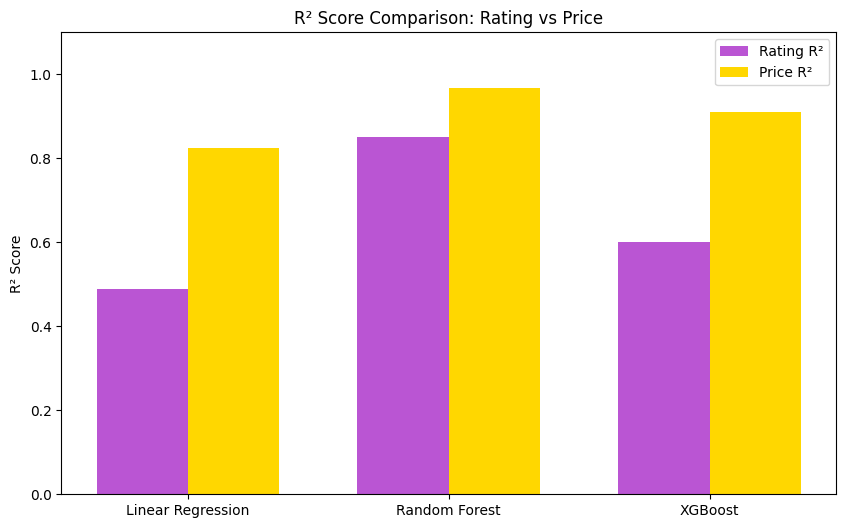

In [43]:

print(" Plotting R² Score Comparison...")

import matplotlib.pyplot as plt
import numpy as np

models = ['Linear Regression', 'Random Forest', 'XGBoost']
r2_rating = [0.489, 0.850, 0.601]
r2_price = [0.824, 0.967, 0.910]
x = np.arange(len(models))
width = 0.35


plt.figure(figsize=(10,6))
plt.bar(x - width/2, r2_rating, width, label='Rating R²', color='mediumorchid')
plt.bar(x + width/2, r2_price, width, label='Price R²', color='gold')

plt.xticks(x, models)
plt.ylabel('R² Score')
plt.ylim(0, 1.1)
plt.title('R² Score Comparison: Rating vs Price')
plt.legend()
plt.show()
